# **LAB 6 - IA 340 - Idaho - David Korte**

In [2]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [3]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [4]:
sql = """
     select * from population
     where fips = '16'
     """

# Q1 Explanation:
The chart shows Idaho's year-over-year population growth from 2005 to 2019. Population growth peaked in 2006 (5%+) and has remained relatively consistent at between 1-2% from 2007 to 2019. In 2011 and 2012, population growth was under 1%. Several years show slight negative growth (2007, 2008, 2009, 2010, 2011), indicating small population growth during these years. Since 2012, population growth has been relatively on the rise. 

In [5]:
import pandas as pd

me_df = pd.read_sql(sql, con=conn)
me_df.head() #show the top 5 rows

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_6360/1655376101.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  me_df = pd.read_sql(sql, con=conn)


,fips,pop,year
0,16,1395634,2005
1,16,1466465,2006
2,16,1499402,2007
3,16,1523816,2008
4,16,1545801,2009


In [7]:
q1_sql = """
SELECT
  year,
  pop,
  ROUND(
    100.0 * (pop - LAG(pop) OVER (ORDER BY year))
    / NULLIF(LAG(pop) OVER (ORDER BY year), 0),
    2
  ) AS growth_rate_pct
FROM population
WHERE fips = '16'
ORDER BY year;
"""
q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head()

/tmp/ipykernel_6360/1728929635.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,year,pop,growth_rate_pct
0,2005,1395634,NaN
1,2006,1466465,5.08
2,2007,1499402,2.25
3,2008,1523816,1.63
4,2009,1545801,1.44


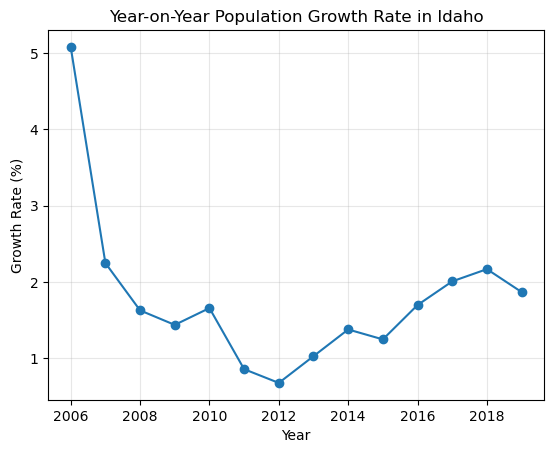

In [8]:
import matplotlib.pyplot as plt

plt.plot(q1_df["year"], q1_df["growth_rate_pct"], marker="o")
plt.title("Year-on-Year Population Growth Rate in Idaho")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.grid(True, alpha=0.3)
plt.show()


# Q2 Explanation:  
In the dual-axis chart, the population (in red) increases from approximately 1.4 million to around 1.8 million between 2005 and 2019. The median household income (green) rises from 2005 to 2008, then decreases from 2008 to 2011. The data suggest that household income somewhat correlates with population due to small population growth with a decrease in income level. This can be attributed to the economy, making it more challenging for people to move around. Also, the decline in income can most likely be attributed to the Great Recession.


In [9]:
q2_sql = """
SELECT
  p.year,
  p.pop AS population,
  i.income AS median_income
FROM population p
JOIN income i
  ON p.fips = i.fips
 AND p.year = i.year
WHERE p.fips = '16'
ORDER BY p.year;
"""
q2_df = pd.read_sql(q2_sql, con=conn)   # <— use conn here
q2_df.head()

/tmp/ipykernel_6360/2432597450.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)   # <— use conn here


,year,population,median_income
0,2005,1395634,41443
1,2006,1466465,42865
2,2007,1499402,46253
3,2008,1523816,47576
4,2009,1545801,44926


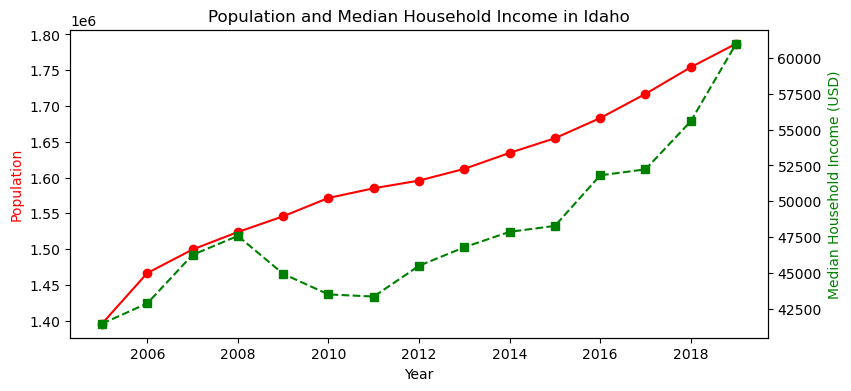

In [12]:
fig, ax1 = plt.subplots(figsize=(9,4))

# Left axis: Population
ax1.plot(q2_df["year"], q2_df["population"], marker="o", color="red")
ax1.set_xlabel("Year")
ax1.set_ylabel("Population", color="red")

# Right axis: Income
ax2 = ax1.twinx()
ax2.plot(q2_df["year"], q2_df["median_income"], marker="s", linestyle="--", color="green")
ax2.set_ylabel("Median Household Income (USD)", color="green")

plt.title("Population and Median Household Income in Idaho")
plt.show()

# Q3 Explanation:
The chart shows the increase in population by people instead of looking at the growth rate. In 2006, the largest population increase was observed, with 70,831 people, and the smallest population increase was in 2012, with 10,743. Overall, Idaho's population growth has been on the rise since 2012, with an average increase of around 25,000 people. 

In [20]:
q3_sql = """
WITH pop_series AS (
  SELECT
    year,
    pop,
    LAG(pop) OVER (ORDER BY year) AS prev_pop
  FROM population
  WHERE fips = '16'
)
SELECT
  year,
  pop,
  (pop - prev_pop) AS yoy_change
FROM pop_series
WHERE prev_pop IS NOT NULL
LIMIT 15;
"""
q3_df = pd.read_sql(q3_sql, con=conn)
q3_df

/tmp/ipykernel_6360/2985309431.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3_df = pd.read_sql(q3_sql, con=conn)


,year,pop,yoy_change
0,2006,1466465,70831
1,2007,1499402,32937
2,2008,1523816,24414
3,2009,1545801,21985
4,2010,1571450,25649
5,2011,1584985,13535
6,2012,1595728,10743
7,2013,1612136,16408
8,2014,1634464,22328
9,2015,1654930,20466


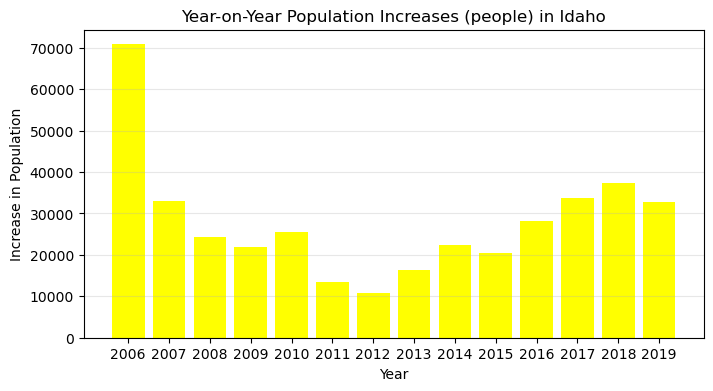

In [21]:
plt.figure(figsize=(8,4))
plt.bar(q3_df["year"].astype(str), q3_df["yoy_change"], color="yellow")
plt.title("Year-on-Year Population Increases (people) in Idaho")
plt.xlabel("Year")
plt.ylabel("Increase in Population")
plt.grid(True, axis='y', alpha=0.3)
plt.show()